## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: It's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious  scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
accuracy_score, plot_roc_curve, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report, plot_confusion_matrix

# Import warnings
import warnings
warnings.filterwarnings("ignore")

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [2]:
df = pd.read_csv("chronic_kidney_disease_full.csv")

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: Age, Blood Pressure, Red Blood Cell Count, Blood urea, Hemoglobin and Anemia might be interesting features.

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [3]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

In [4]:
drop = df.dropna()
print(f"Original Dataframe with all missing value row:{df.shape}")
print(f"Remaining Dataframe after drop all missing value row:{drop.shape}")

Original Dataframe with all missing value row:(400, 25)
Remaining Dataframe after drop all missing value row:(158, 25)


Answer: 158 rows would remain in our dataframe. 
There are many downsides:
1. We would not have enough training data for the model. This would result in the model missing
important features.
2. The missing data might not be missing completely random as some patients might not need
certain tests depending on the symptoms and conditions.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:
1. The data might be gathered at a different time which result in a bias as the body would work differently according to the time of day.
2. They might be in an emergency situation and their recall of the values when records might be off slightly. 
3. The labs equipment might have different unit and margin of error. Moreover, the rounding and transforming unit might be inaccurate.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has chronic kidney disease (CKD) will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: The model would predict that every person has CKD.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We optimise for Sensitivity (True positive rate) or False Negative rate. We minimize for False Negative (Type II error).

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: One of the disadvantages is the number of False Positives (Type I error) increases significantly. A large proportion of people might worry about a disease that they do not have which could change their lifestyle dramatically. Furthermore, the patients might need to seek unnecessary treatments which could harm their body and finance considerably.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: The model would predict that every person does not have CKD.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:  We optimise for Specificity (True negative rate) or False Positive rate. We minimize for False Positive (Type I error).

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: The model would not diagnose people with CKD who need treatments. This would lead to financial and reputation damage to the doctors and hospitals involved as it is a serious negligent case.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

In [6]:
df.fillna(0,inplace=True)
# We would assume missing data is normal as it is not test or required by the doctor.

In [7]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,0,normal,notpresent,notpresent,0.0,...,38.0,6000.0,0.0,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,0.0,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [8]:
print(df["class"])

0         ckd
1         ckd
2         ckd
3         ckd
4         ckd
        ...  
395    notckd
396    notckd
397    notckd
398    notckd
399    notckd
Name: class, Length: 400, dtype: object


In [9]:
object_df = df.select_dtypes(include="object")

In [10]:
object_df.columns

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
       'class'],
      dtype='object')

In [11]:
# Loop through all object columns
for i in object_df.columns:
    df[i]= df[i].map({"normal":0,"abnormal":1,
                      "notpresent":0, "present":1,
                      "no":0,"yes":1,
                      "good":0,"poor":1, # Good appetite == Normal, Poor appetite == abnormal
                      "notckd":0,"ckd":1})

In [12]:
# df.fillna(0,inplace=True) 
# We assumed that missing data is normal due to not required testings.
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,1.0,1.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,0.0,...,38.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31.0,7500.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32.0,6700.0,3.9,1.0,0.0,0.0,1.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0.0,0.0,0.0,0.0,0.0,0.0,1


In [13]:
df.fillna(0,inplace=True)
# We would assume missing data is normal as it is not test or required by the doctor.

In [14]:
df["class"].mean()

0.625

In [15]:
df.columns
X = df.drop("class", axis = 1)
y = df["class"]

In [16]:
y.mean()

0.625

In [17]:
sc = StandardScaler()
X_train, X_test, y_train, y_test =  train_test_split(X,y, random_state=42)
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [18]:
# Instantiate Logistic Regression Model
logreg = LogisticRegression()

# Train or Fit
logreg.fit(X_train_sc, y_train)

# Check Train and Test Score
print(f"Train Score {logreg.score(X_train_sc, y_train)}")
print(f"Test Score {logreg.score(X_test_sc, y_test)}")

Train Score 0.9833333333333333
Test Score 0.98


---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [19]:
df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [20]:
logreg.coef_

array([[-0.00395853, -0.06990955, -0.45407897,  1.49229361,  0.38985127,
         0.64505868,  0.82777857,  0.02786013,  0.00619677,  0.74968328,
         0.5178869 ,  1.80433055, -0.76697528, -0.74015671,  0.13744995,
        -0.4783219 ,  0.72625409, -1.77880068,  1.03021989,  0.98211218,
         0.2492805 ,  0.72072429,  0.60134094,  0.5390202 ]])

In [21]:
# The coefficient of age (beta1) can be intrepreted as a 1 unit increases 
# (one year increases) would increase the likelyhood of CKD by 0.2655% 
# ceteris paribus (holding all else constant).

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [22]:
# The coefficient of rbc or red blood count (beta6) can be intrepreted as abnormal 
# would increase the likelyhood of CKD by 0.5122% 
# ceteris paribus (holding all else constant).

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:
1. Logistic regression have coefficients (statistical parameter) a.k.a. beta which can be used for explaination of the impacts of the factors. Interpretability and magnitude of features are very useful. 
2. Logistic regression is easier to implement without overfitting. 

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [23]:
#from sklearn.metrics import confusion_matrix
# Training predictions
y_train_preds = logreg.predict(X_train_sc)
cm_train = confusion_matrix(y_train,y_train_preds)
cm_train

array([[114,   1],
       [  4, 181]], dtype=int64)

In [24]:
# Testing Predictions
y_preds = logreg.predict(X_test_sc)
cm = confusion_matrix(y_test,y_preds)
cm

array([[35,  0],
       [ 2, 63]], dtype=int64)

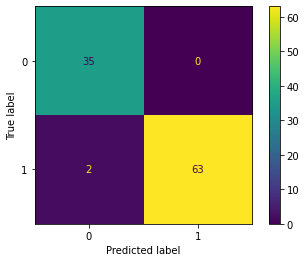

In [25]:
plot_confusion_matrix(logreg,X_test_sc,y_test);

Confusion Matrix is very useful for optimising the model as there is a tradeoff between False Negative and False Positive Values. Likely, the cost of False Negative and False Positive differs significantly. 

We can further optimise the model using recall and precision to minimise the costly target error.

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: We want to optimise for specificity (false negative rate) because the damage from lawsuits and negligent cases are likely to be more costly to the hospital and doctors compared to false positive cases. Most patients are likely to have a second opinion and further tests to confirm the existance of the diesease which significantly reduce false positve.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [26]:
sc = StandardScaler()
X_train, X_test, y_train, y_test =  train_test_split(X,y,random_state=42)
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [27]:
# Instantiate Logistic Regression Model from Q12
logreg = LogisticRegression()

# Train or Fit
logreg.fit(X_train_sc, y_train)

# Check Train and Test Score
print(f"Train Score {logreg.score(X_train_sc, y_train)}")
print(f"Test Score {logreg.score(X_test_sc, y_test)}")

Train Score 0.9833333333333333
Test Score 0.98


In [28]:
y_preds = logreg.predict(X_test_sc)
y_preds[:10]

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1], dtype=int64)

In [29]:
probs = logreg.predict_proba(X_test_sc)
probs[:10]

array([[7.17013619e-02, 9.28298638e-01],
       [9.23740560e-01, 7.62594404e-02],
       [1.35717663e-06, 9.99998643e-01],
       [9.63655600e-08, 9.99999904e-01],
       [2.52546473e-08, 9.99999975e-01],
       [7.00638016e-08, 9.99999930e-01],
       [9.75645964e-01, 2.43540363e-02],
       [3.03344830e-01, 6.96655170e-01],
       [9.71701100e-01, 2.82988996e-02],
       [9.69696212e-04, 9.99030304e-01]])

In [30]:
cm = confusion_matrix(y_test, y_preds)
cm

array([[35,  0],
       [ 2, 63]], dtype=int64)

In [58]:
# Create function
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

In [60]:
y_pred_df = pd.DataFrame(logreg.predict_proba(X_test_sc), 
                    columns=['class_0', 'class_1'])
for i in range(0,101):
    y_pred_df["Threshold"+str(i)] = [1 if x >= i/100 else 0 \
                              for x in y_pred_df['class_1'].values] # Prediction at each Threshold
    preds = get_predictions(logreg.predict_proba(X_test_sc)[:,1], i/100)
    acc = accuracy_score(y_test, preds)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    if i%25 ==0:
        print(f"Threshold: {int(i)}%,\nAccuracy: \
        {acc:.4f}\nFalse Positives: {fp} \nFalse Negatives {fn}\n" ) 

Threshold: 0%,
Accuracy:         0.6500
False Positives: 35 
False Negatives 0

Threshold: 25%,
Accuracy:         0.9900
False Positives: 1 
False Negatives 0

Threshold: 50%,
Accuracy:         0.9800
False Positives: 0 
False Negatives 2

Threshold: 75%,
Accuracy:         0.9700
False Positives: 0 
False Negatives 3

Threshold: 100%,
Accuracy:         0.3500
False Positives: 0 
False Negatives 65



In [55]:
y_pred_df.head()

,class_0,class_1,Threshold0,Threshold1,Threshold2,Threshold3,Threshold4,Threshold5,Threshold6,Threshold7,...,Threshold91,Threshold92,Threshold93,Threshold94,Threshold95,Threshold96,Threshold97,Threshold98,Threshold99,Threshold100
0,7.170136e-02,0.928299,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
1,9.237406e-01,0.076259,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1.357177e-06,0.999999,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
3,9.636556e-08,1.000000,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
4,2.525465e-08,1.000000,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


In [54]:
print("Frequency of Prediction at 0%: " + str(y_pred_df["Threshold0"].mean()))
print("Frequency of Prediction at 25%: " + str(y_pred_df["Threshold25"].mean()))
print("Frequency of Prediction at 50%: " + str(y_pred_df["Threshold50"].mean()))
print("Frequency of Prediction at 75%: " + str(y_pred_df["Threshold75"].mean()))
print("Frequency of Prediction at 100%: " + str(y_pred_df["Threshold100"].mean()))

Frequency of Prediction at 0%: 1.0
Frequency of Prediction at 25%: 0.66
Frequency of Prediction at 50%: 0.63
Frequency of Prediction at 75%: 0.62
Frequency of Prediction at 100%: 0.0


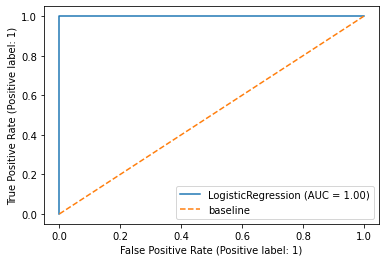

In [33]:
plot_roc_curve(logreg, X_test_sc, y_test)
plt.plot([0,1], [0,1], label='baseline', linestyle='--')
plt.legend();

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

In [34]:
df["class"].value_counts()

1    250
0    150
Name: class, dtype: int64

In [35]:
df["class"].value_counts(normalize=True)*100

1    62.5
0    37.5
Name: class, dtype: float64

Answer: Imbalanced classes are generally a problem as the model would predict the majority class most of the time and perform poorly on predicting the minority class.

They are not a major problem in this CKD analysis as the minority class is higher than 20% which is a mild imbalance.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: Unbalanced classes are generally a problem as the model does not have training data for the minority class similar to a doctor having a patient with a rare disease. The model would perform well with common diseases from past experience (training data) but perform poorly on rare diseases.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [36]:
df["class"].mean()
ckd_df = df[df["class"] == 1].sample(n=200000,
                                    replace=True,
                                    random_state=42)

frames = [df,ckd_df]
new_df = pd.concat(frames) # combine two dataframes

print(new_df.shape) # check shape
print((1-new_df["class"]).mean()) # Unbalanced Dataset with 200,000 rows with 0.00075% non-CKD

(200400, 25)
0.0007485029940119761


In [37]:
new_df["class"].value_counts()

1    200250
0       150
Name: class, dtype: int64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [38]:
new_df.columns
X_new = new_df.drop("class", axis = 1)
y_new = new_df["class"]

In [39]:
sc = StandardScaler()
X_new_train, X_new_test, y_new_train, y_new_test =  train_test_split(X_new,y_new,random_state=42)
X_new_train_sc = sc.fit_transform(X_new_train)
X_new_test_sc = sc.transform(X_new_test)

In [40]:
logreg_unbalanced = LogisticRegression()
logreg_unbalanced.fit(X_new_train_sc,y_new_train)

LogisticRegression()

In [41]:
# Check Train and Test Score
print(f"Train Score {logreg_unbalanced.score(X_new_train_sc, y_new_train)}")
print(f"Test Score {logreg_unbalanced.score(X_new_test_sc, y_new_test)}")

Train Score 0.9999068529607452
Test Score 0.9997005988023953


In [42]:
#from sklearn.metrics import confusion_matrix
# Training predictions of new unbalanced dataset
y_new_train_preds = logreg_unbalanced.predict(X_new_train_sc)
cm_train = confusion_matrix(y_new_train,y_new_train_preds)
cm_train

array([[    87,     14],
       [     0, 150199]], dtype=int64)

In [43]:
# Testing Predictions
y_new_preds = logreg.predict(X_new_test_sc)
cm = confusion_matrix(y_new_test,y_new_preds)
cm

array([[   49,     0],
       [10940, 39111]], dtype=int64)

In [44]:
print(classification_report(y_new_test,y_new_preds))

              precision    recall  f1-score   support

           0       0.00      1.00      0.01        49
           1       1.00      0.78      0.88     50051

    accuracy                           0.78     50100
   macro avg       0.50      0.89      0.44     50100
weighted avg       1.00      0.78      0.88     50100



In [45]:
#from sklearn.metrics import confusion_matrix
# Original Training predictions
y_train_preds = logreg.predict(X_train_sc)
cm_train = confusion_matrix(y_train,y_train_preds)
cm_train

array([[114,   1],
       [  4, 181]], dtype=int64)

In [46]:
# Testing Predictions
y_preds = logreg.predict(X_test_sc)
cm = confusion_matrix(y_test,y_preds)
cm

array([[35,  0],
       [ 2, 63]], dtype=int64)

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!